In [1]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler

In [2]:
learning_rate=1e-5
width=height=900 # image width and height
batchSize=8

TrainFolder="../LabPicsV1/Simple/Train//"
TestFolder="../LabPicsV1/Simple/Test//"
ListImages=os.listdir(os.path.join(TrainFolder, "Image")) # Create list of images

In [3]:
#Image transforms
transformImg = tf.Compose([
    tf.ToPILImage(), 
    tf.Resize((height, width)), 
    tf.ToTensor(),
    tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
transformAnn = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((height,width), tf.InterpolationMode.NEAREST),
    tf.ToTensor()
])

Load and set net and optimizer

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
#Download the pretrained backbone
Net = torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT') # Load net

In [6]:
total_layers = len(list(Net.parameters()))
print(f"Total number of layers in the model: {total_layers}")

Total number of layers in the model: 187


In [7]:
for name, module in Net.named_children():
    print(f"Module: {name}")
    #print(module)
    print("=" * 50)

Module: backbone
Module: classifier
Module: aux_classifier


In [8]:
#Freeze all parameters
for param in Net.parameters():
    param.requires_grad = False
#Unfreeze last layer of auxilary classifier
for param in Net.aux_classifier[4].parameters():
    param.requires_grad = True
#Unfreeze all classifier layer
for param in Net.classifier.parameters():
    param.requires_grad = True 

In [9]:
# for name, param in Net.named_parameters():
#     print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

In [10]:
#Edit last layer to fit the images and number of classess
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net.aux_classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
Net=Net.to(device)


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform_img, transform_ann):
        self.folder_path = folder_path
        self.list_images = os.listdir(os.path.join(folder_path, "Image"))
        self.transform_img = transform_img
        self.transform_ann = transform_ann

    def __len__(self):
        return len(self.list_images)
    def getlist_names(self):
        return self.list_images

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.folder_path, "Image", self.list_images[idx]))[:, :, 0:3]
        filled = cv2.imread(os.path.join(self.folder_path, "Semantic/16_Filled", self.list_images[idx].replace("jpg", "png")), 0)
        vessel = cv2.imread(os.path.join(self.folder_path, "Semantic/1_Vessel", self.list_images[idx].replace("jpg", "png")), 0)

        ann_map = np.zeros(img.shape[0:2], np.float32)
        if vessel is not None:  
            ann_map[vessel == 1] = 1
        if filled is not None:  
            ann_map[filled == 1] = 2

        img = self.transform_img(img)
        ann_map = self.transform_ann(ann_map)
        ann_map = ann_map.squeeze()

        return img, ann_map

# Create an instance of the custom dataset with transformations
train_dataset = CustomDataset(TrainFolder, transform_img=transformImg, transform_ann=transformAnn)

# Use DataLoader for batch loading
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=0, pin_memory=True)


In [12]:
def train(net, num_epochs, learning_rate):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        net.train()

        current_time = time.time()
        previous_time = time.time()
        avg_step_time = 0

        for i, (images, ann) in enumerate(train_loader):
            images, ann = images.to(device), ann.to(device)
            

            previous_time = current_time
            current_time = time.time()
            step_time = current_time - previous_time
            avg_step_time += step_time / (i+1)

            optimizer.zero_grad()
            pred = net(images)['out']
            loss = criterion(pred, ann.long())
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            print(f'\rEpoch {epoch} [{i+1}/{len(train_loader)}]: Loss={loss.item():.4f} Avg step time={avg_step_time:.2f}s', end='')

        if epoch % 100 == 0:
            print("\nSaving Model" + str(epoch) + ".torch")
            torch.save(net.state_dict(), str(epoch) + ".torch")

        print(f'\nEpoch {epoch} finished! Loss: {epoch_loss / len(train_loader):.2f} Avg ste time: {avg_step_time:.2f}')

    torch.save(net.state_dict(), "Model" + str(num_epochs) + ".torch")

In [16]:
train(Net, 10, learning_rate)

Epoch 0 [212/212]: Loss=0.7326
Saving Model0.torch

Epoch 0 finished! Loss: 0.78
Epoch 1 [187/212]: Loss=0.5356

KeyboardInterrupt: 

In [13]:
modelPath = "Model1.torch"  # Path to trained model
imagePath = "test.jpg"  # Test image

In [14]:
Net.load_state_dict(torch.load(modelPath)) # Load trained model
Net.eval() # Set to evaluation mode
print()

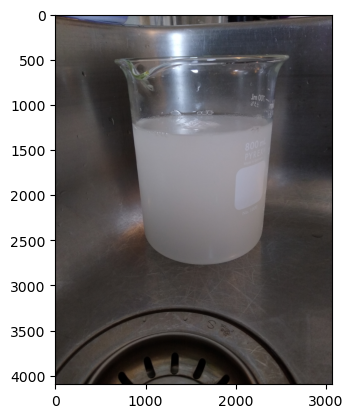

In [15]:
Img = cv2.imread(imagePath) # load test image
height_orgin , widh_orgin ,d = Img.shape # Get image original size 
plt.imshow(Img[:,:,::-1])  # Show image
plt.show()

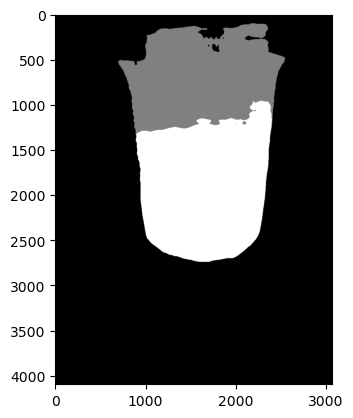

In [16]:
Img = cv2.imread(imagePath) # load test image
# print(Img.shape)
Img = transformImg(Img)  # Transform to pytorch
# print(Img.shape)
Img = Img.to(device).unsqueeze(0)
# print(Img.shape)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
# print(Prd.shape)
Prd = torch.argmax(Prd, 1)  # Get  prediction classes
# print(Prd.shape)
Prd = tf.Resize((height_orgin,widh_orgin), antialias=None)(Prd) # Resize to origninal size
# print(Prd.shape)
seg = Prd.squeeze().cpu().detach().numpy()
plt.imshow(seg, cmap='gray')
plt.show()

In [17]:
subset_start = 0
subset_end = 10

test_dataset = CustomDataset(TestFolder, transform_img=transformImg, transform_ann=transformAnn)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False, num_workers=0, pin_memory=True, sampler=SequentialSampler(range(subset_start, subset_end)))

In [18]:
Net.load_state_dict(torch.load(modelPath))
Net.eval()
print()

In [19]:
LABEL_TO_COLOR = {0: [0, 0, 0], 1: [128, 128, 128], 2: [255, 255, 255]}

def mask2rgb(mask):
    rgb = np.zeros(mask.shape + (3,), dtype=np.uint8)
    
    for label, color in LABEL_TO_COLOR.items():
        rgb[mask == label] = color
    
    return rgb

def rgb2mask(rgb):
    mask = np.zeros(rgb.shape[:2], dtype=np.uint8)

    for label, color in LABEL_TO_COLOR.items():
        mask[np.all(rgb == color, axis=2)] = label
        
    return mask

def get_dataset(path_folder, sl=slice(None)):
    list_images = os.listdir(os.path.join(path_folder, "Image"))
    images = []
    true_mask = []
    for idx in range(len(list_images)):
        img = cv2.imread(os.path.join(path_folder, "Image", list_images[idx]))[:, :, 0:3]
        filled = cv2.imread(os.path.join(path_folder, "Semantic/16_Filled", list_images[idx].replace("jpg", "png")), 0)
        vessel = cv2.imread(os.path.join(path_folder, "Semantic/1_Vessel", list_images[idx].replace("jpg", "png")), 0)
        
        ann_map = np.zeros(img.shape[0:2], np.float32)
        if vessel is not None: ann_map[vessel == 1] = 1
        if filled is not None: ann_map[filled == 1] = 2
        
        images.append(img)
        true_mask.append(ann_map)
        
    return images[sl], true_mask[sl]

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score

import os
from PIL import Image

os.makedirs("predicted_masks", exist_ok=True)

for i, (images, ann) in enumerate(test_loader):
    # org_imgs, org_masks = get_dataset(TestFolder, slice=slice(batchSize*i, batchSize*(i+1)))
    images = images.to(device)

    with torch.no_grad():
        pred = Net(images)['out']
    pred = torch.argmax(pred, 1).cpu().detach().numpy()

    for j in range(pred.shape[0]):
        # new_size = org_imgs[j].shape[:2][::-1]
        # pred[j] = cv2.resize(pred[j], new_size)
        pred_mask = Image.fromarray(mask2rgb(pred[j]))
        pred_mask.save(os.path.join("predicted_masks", f"pred_mask_{j}.png"))
    
    # pred_mask = pred.tolist()
    # true_mask_flat = [mask.flatten() for mask in org_masks]
    # pred_mask_flat = [mask.flatten() for mask in pred_mask]
      
    # iou_per_class = jaccard_score(np.concatenate(true_mask_flat), np.concatenate(pred_mask_flat), average=None)
    # miou = np.mean(iou_per_class)
    # print(f"Batch {i}  Class 0: {iou_per_class[0]:.4f} Class 1: {iou_per_class[1]:.4f} Class 2: {iou_per_class[2]:.4f} Mean IoU: {miou:.4f}")

    print(f'\rBatch {i+1}/{len(test_loader)} processed.', end='')

Batch 2/2 processed.

In [21]:
images = []
true_mask = []
pred_mask = []

list_images = os.listdir("predicted_masks")[:10]
for idx in range(len(list_images)):
    pred = cv2.imread(os.path.join("predicted_masks", list_images[idx]))

    pred_mask.append(rgb2mask(pred))

images, true_mask = get_dataset(TestFolder, slice(None,len(pred_mask)))

for i in range(len(images)):
    new_size = images[i].shape[:2][::-1]
    pred_mask[i] = cv2.resize(pred_mask[i], new_size)


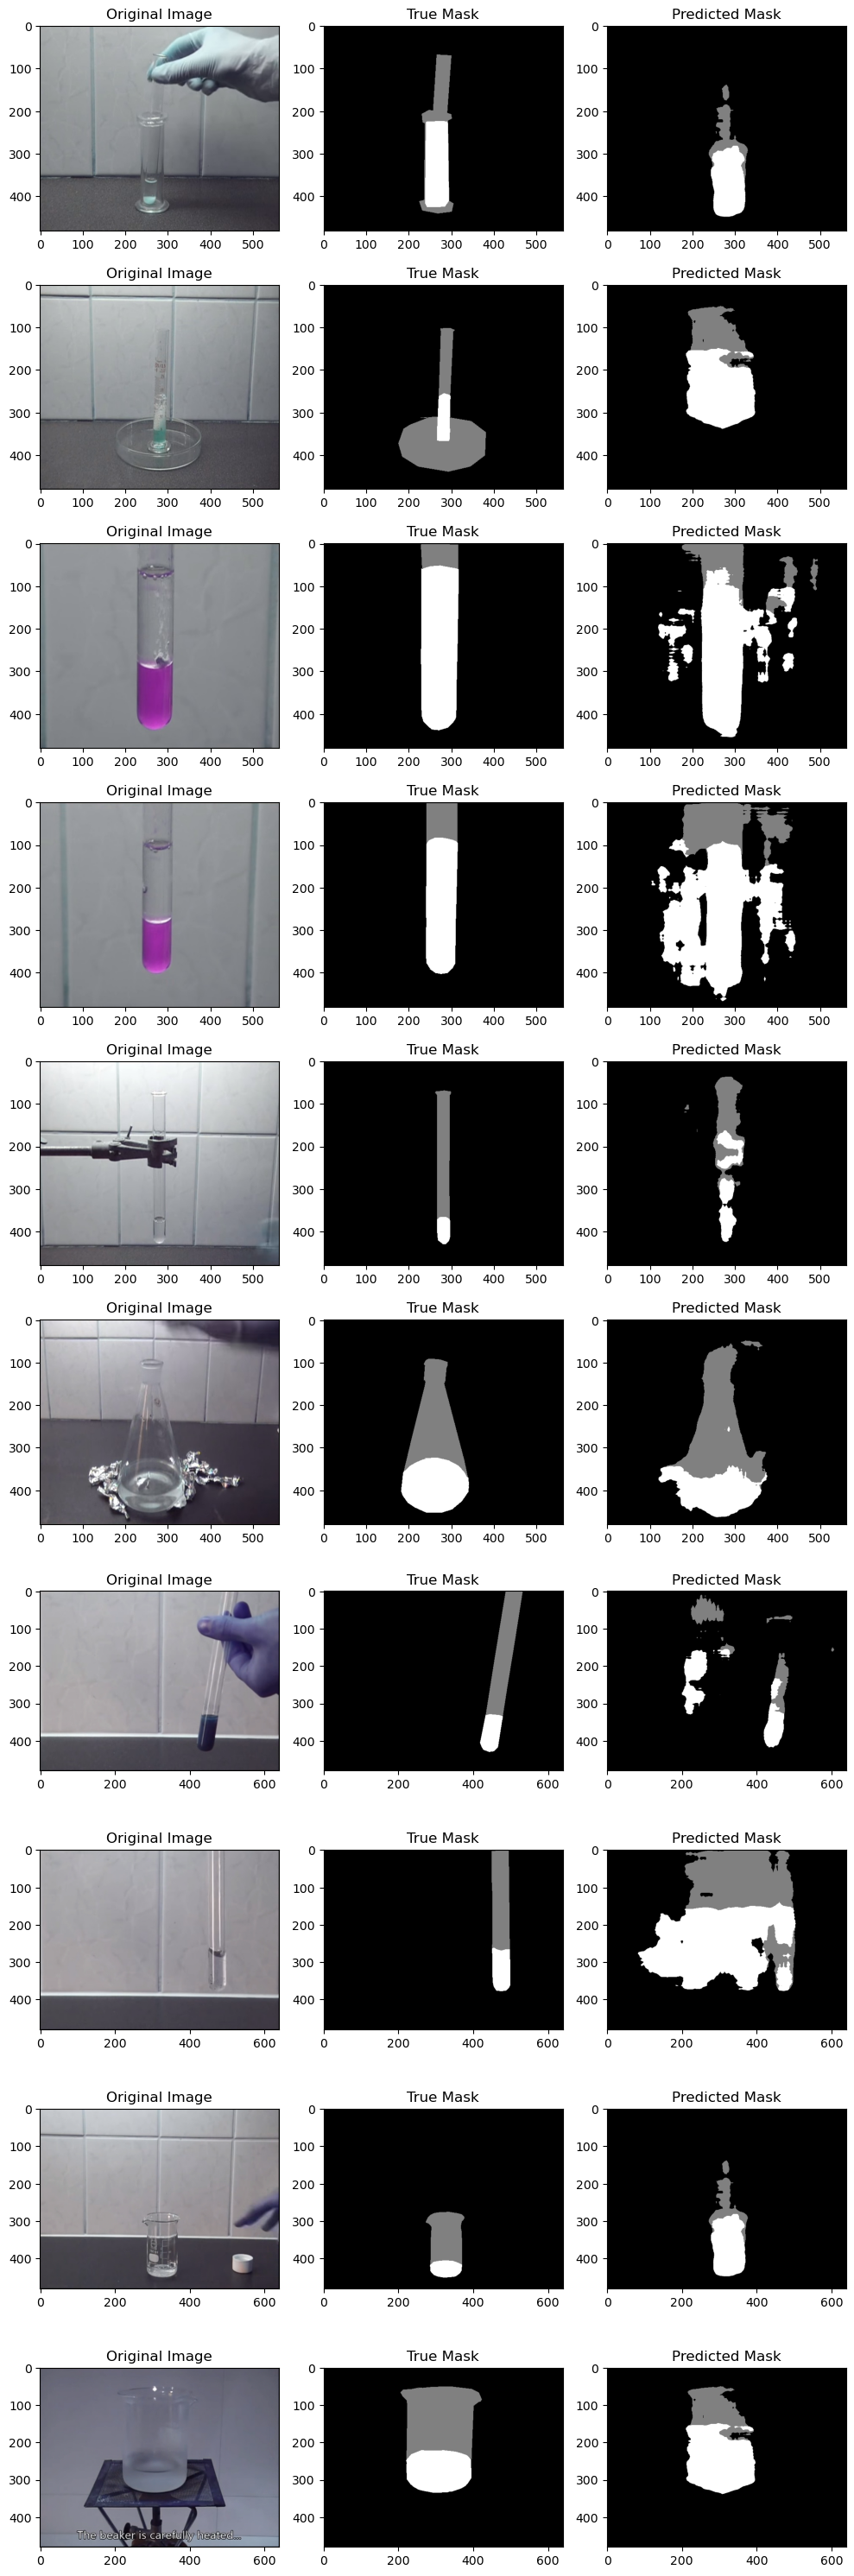

In [22]:
import matplotlib.pyplot as plt


num_rows = len(pred_mask)
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows))

for i in range(num_rows):
    # Display the original image
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Original Image')

    # Display the true mask
    axes[i, 1].imshow(true_mask[i], cmap='gray')
    axes[i, 1].axis('on')
    axes[i, 1].set_title('True Mask')

    # Display the predicted mask
    axes[i, 2].imshow(pred_mask[i], cmap='gray')
    axes[i, 2].axis('on')
    axes[i, 2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score

true_mask_flat = [mask.flatten() for mask in true_mask]
pred_mask_flat = [mask.flatten() for mask in pred_mask]

conf_matrix = confusion_matrix(np.concatenate(true_mask_flat), np.concatenate(pred_mask_flat))

iou_per_class = jaccard_score(np.concatenate(true_mask_flat), np.concatenate(pred_mask_flat), average=None)

miou = np.mean(iou_per_class)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nJaccard Index (IoU) per class:")
for class_idx, iou in enumerate(iou_per_class):
    print(f"Class {class_idx}: {iou:.4f}")

print("\nMean IoU (mIoU):", miou)

Confusion Matrix:
[[2344863   91392  153717]
 [  44738   63763   33087]
 [   5562   12286   97952]]

Jaccard Index (IoU) per class:
Class 0: 0.8881
Class 1: 0.2600
Class 2: 0.3237

Mean IoU (mIoU): 0.4905953468211675
